In [1840]:
import pandas as pd
import pyodbc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import warnings

In [1845]:
import pyodbc
import pandas as pd

# 🔌 Connexion à SQL Server
conn = pyodbc.connect(
    "DRIVER={SQL Server};"
    "SERVER=DESKTOP-9MQ1CAL;"
    "DATABASE=DW_FINANCE;"
    "Trusted_Connection=yes;"
)
cursor = conn.cursor()

# ✅ 1. Ajouter la colonne IsLate si elle n'existe pas
try:
    cursor.execute("""
        ALTER TABLE Fact_Supply
        ADD IsLate INT;
    """)
    print("✅ Colonne 'IsLate' ajoutée.")
except Exception as e:
    print("ℹ️ Colonne déjà existante ou erreur :", e)

# 📥 2. Charger les données et calculer IsLate
df_supply = pd.read_sql("SELECT * FROM Fact_Supply", conn)

# ⚠️ S'assurer que 'DueDate' et 'PaymentDate' sont bien au format AAAAMMJJ (int)
df_supply["IsLate"] = (df_supply["PaymentDate"] > df_supply["DueDate"]).astype(int)

# 🔁 3. Mise à jour dans SQL Server ligne par ligne
print(f"🔄 Mise à jour de {len(df_supply)} lignes...")
for index, row in df_supply.iterrows():
    cursor.execute("""
        UPDATE Fact_Supply
        SET IsLate = ?
        WHERE InvoiceID = ?
    """, int(row["IsLate"]), int(row["InvoiceID"]))

# ✅ Sauvegarder
conn.commit()
cursor.close()

# 📋 Vérification
result = pd.read_sql("""
    SELECT TOP 10 InvoiceID, DueDate, PaymentDate, IsLate
    FROM Fact_Supply
    ORDER BY InvoiceID DESC
""", conn)


print("📌 Exemple de lignes mises à jour :")
print(result)


ℹ️ Colonne déjà existante ou erreur : ('42S21', "[42S21] [Microsoft][ODBC SQL Server Driver][SQL Server]Column names in each table must be unique. Column name 'IsLate' in table 'Fact_Supply' is specified more than once. (2705) (SQLExecDirectW)")
🔄 Mise à jour de 942 lignes...


C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_31940\1768616198.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_supply = pd.read_sql("SELECT * FROM Fact_Supply", conn)


📌 Exemple de lignes mises à jour :
   InvoiceID  DueDate  PaymentDate  IsLate
0       9118     1193         3447       1
1       9114     2529         4825       1
2       9110     1043         2989       1
3       9109     1185         4106       1
4       9102     2833         3582       1
5       9096     2817         4182       1
6       9087     2058         3932       1
7       9085     1771         5335       1
8       9080     2218         5282       1
9       9039     1137         5433       1


C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_31940\1768616198.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql("""


In [1851]:
df_supply = pd.read_sql("SELECT * FROM Fact_Supply", conn)
df_supply.head()

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_31940\3751972479.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_supply = pd.read_sql("SELECT * FROM Fact_Supply", conn)


,InvoiceID,SupplierID,PaymentID,DisputeFK,DisputeDate,ResolutionDate,InvoiceDate,DueDate,PaymentDueDate,PaymentDate,Amount,DiscountOffered,DiscountUsed,IsLate
0,13,90,Pay-8752,6995,5280,5446,4953,4981,0,4105,1622.80,353.65,329.28,0
1,34,91,Pay-8722,6986,4301,5401,4956,5037,0,5563,1511.69,467.58,428.68,1
2,59,87,PM8741,6994,5297,5466,4905,4933,0,4222,1518.47,134.50,130.55,0
3,60,90,Pay-8784,6995,5280,5446,3912,3955,0,3538,3325.78,33.43,9.70,0
4,65,89,Pay-8640,6979,4415,5456,5181,5224,0,4094,2290.75,427.86,171.71,0


In [1849]:
df_supply.drop("PaymentDueDate", axis=1, inplace=True)

In [1748]:
df_date = pd.read_sql("SELECT * FROM DIM_Date", conn)
df_date.head()

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_31940\170201818.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_date = pd.read_sql("SELECT * FROM DIM_Date", conn)


,DateKey,Date,Year,Quarter,Month,MonthName,Day,DayOfWeek,DayOfWeekName,WeekOfYear,IsWeekend
0,1,2010-01-01,2010,1,1,January,1,6,Friday,1,False
1,2,2010-01-02,2010,1,1,January,2,7,Saturday,1,True
2,3,2010-01-03,2010,1,1,January,3,1,Sunday,2,True
3,4,2010-01-04,2010,1,1,January,4,2,Monday,2,False
4,5,2010-01-05,2010,1,1,January,5,3,Tuesday,2,False


In [1750]:
df_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6209 entries, 0 to 6208
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   DateKey        6209 non-null   int64 
 1   Date           6209 non-null   object
 2   Year           6209 non-null   int64 
 3   Quarter        6209 non-null   int64 
 4   Month          6209 non-null   int64 
 5   MonthName      6209 non-null   object
 6   Day            6209 non-null   int64 
 7   DayOfWeek      6209 non-null   int64 
 8   DayOfWeekName  6209 non-null   object
 9   WeekOfYear     6209 non-null   int64 
 10  IsWeekend      6209 non-null   bool  
dtypes: bool(1), int64(7), object(3)
memory usage: 491.3+ KB


In [1827]:
df_supply.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   InvoiceID        942 non-null    int64  
 1   SupplierID       942 non-null    int64  
 2   PaymentID        942 non-null    object 
 3   DisputeFK        942 non-null    int64  
 4   DisputeDate      942 non-null    int64  
 5   ResolutionDate   942 non-null    int64  
 6   InvoiceDate      942 non-null    int64  
 7   DueDate          942 non-null    int64  
 8   PaymentDueDate   942 non-null    int64  
 9   PaymentDate      942 non-null    int64  
 10  Amount           942 non-null    float64
 11  DiscountOffered  942 non-null    float64
 12  DiscountUsed     942 non-null    float64
 13  IsLate           942 non-null    int32  
dtypes: float64(3), int32(1), int64(9), object(1)
memory usage: 99.5+ KB


In [1853]:
# 1. Jointure pour DueDate (avec date réelle)
df_supply = df_supply.merge(
    df_date.rename(columns={"DateKey": "DueDate", "Date": "DueDate_Real"}),
    on="DueDate",
    how="left"
)

# 2. Jointure pour PaymentDate (avec date réelle)
df_supply = df_supply.merge(
    df_date.rename(columns={"DateKey": "PaymentDate", "Date": "PaymentDate_Real"}),
    on="PaymentDate",
    how="left"
)

# 3. Jointure pour InvoiceDate (avec date réelle)
df_supply = df_supply.merge(
    df_date.rename(columns={"DateKey": "InvoiceDate", "Date": "InvoiceDate_Real"}),
    on="InvoiceDate",
    how="left"
)

# 4. Convertir les dates en datetime
df_supply["DueDate"] = pd.to_datetime(df_supply["DueDate_Real"])
df_supply["PaymentDate"] = pd.to_datetime(df_supply["PaymentDate_Real"])
df_supply["InvoiceDate"] = pd.to_datetime(df_supply["InvoiceDate_Real"])

# 5. Supprimer les colonnes inutiles
colonnes_a_supprimer = [col for col in df_supply.columns if "_Real" in col or "_x" in col or "_y" in col]
df_supply.drop(columns=colonnes_a_supprimer, inplace=True)

# 6. Recalculer les deltas de dates
df_supply["DaysToPay"] = (df_supply["PaymentDate"] - df_supply["InvoiceDate"]).dt.days
df_supply["DaysLate"] = (df_supply["PaymentDate"] - df_supply["DueDate"]).dt.days


In [1855]:
df_supply.head()

,InvoiceID,SupplierID,PaymentID,DisputeFK,DisputeDate,ResolutionDate,InvoiceDate,DueDate,PaymentDueDate,PaymentDate,...,Quarter,Month,MonthName,Day,DayOfWeek,DayOfWeekName,WeekOfYear,IsWeekend,DaysToPay,DaysLate
0,13,90,Pay-8752,6995,5280,5446,2023-07-24,2023-08-21,0,2021-03-28,...,3,7,July,24,2,Monday,30,False,-848,-876
1,34,91,Pay-8722,6986,4301,5401,2023-07-27,2023-10-16,0,2025-03-25,...,3,7,July,27,5,Thursday,30,False,607,526
2,59,87,PM8741,6994,5297,5466,2023-06-06,2023-07-04,0,2021-07-23,...,2,6,June,6,3,Tuesday,23,False,-683,-711
3,60,90,Pay-8784,6995,5280,5446,2020-09-16,2020-10-29,0,2019-09-08,...,3,9,September,16,4,Wednesday,38,False,-374,-417
4,65,89,Pay-8640,6979,4415,5456,2024-03-08,2024-04-20,0,2021-03-17,...,1,3,March,8,6,Friday,10,False,-1087,-1130


In [1857]:
# 5. Vérification
print("✅ Structure finale :")
print(df_supply.info())

✅ Structure finale :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   InvoiceID        942 non-null    int64         
 1   SupplierID       942 non-null    int64         
 2   PaymentID        942 non-null    object        
 3   DisputeFK        942 non-null    int64         
 4   DisputeDate      942 non-null    int64         
 5   ResolutionDate   942 non-null    int64         
 6   InvoiceDate      942 non-null    datetime64[ns]
 7   DueDate          942 non-null    datetime64[ns]
 8   PaymentDueDate   942 non-null    int64         
 9   PaymentDate      942 non-null    datetime64[ns]
 10  Amount           942 non-null    float64       
 11  DiscountOffered  942 non-null    float64       
 12  DiscountUsed     942 non-null    float64       
 13  IsLate           942 non-null    int64         
 14  Year             942 

In [1859]:
import pandas as pd

# On suppose que df_supply est déjà chargé et contient la colonne "IsLate"
# Exemple : IsLate = 1 si paiement en retard, sinon 0

# Calcul du total de paiements
total = len(df_supply)

# Calcul du nombre de paiements en retard
late = df_supply["IsLate"].sum()

# Calcul du pourcentage
percent_late = (late / total) * 100

# Affichage
print(f"📊 Pourcentage de paiements en retard : {percent_late:.2f}%")


📊 Pourcentage de paiements en retard : 52.55%


In [1861]:
df_supply['DiscountRatio'] = df_supply['DiscountUsed'] / (df_supply['DiscountOffered'] + 1e-6)
df_supply['DaysToPay'] = (df_supply['PaymentDate'] - df_supply['InvoiceDate']).dt.days
df_supply['DaysLate'] = (df_supply['PaymentDate'] - df_supply['DueDate']).dt.days


In [1863]:
df_supply.head()

,InvoiceID,SupplierID,PaymentID,DisputeFK,DisputeDate,ResolutionDate,InvoiceDate,DueDate,PaymentDueDate,PaymentDate,...,Month,MonthName,Day,DayOfWeek,DayOfWeekName,WeekOfYear,IsWeekend,DaysToPay,DaysLate,DiscountRatio
0,13,90,Pay-8752,6995,5280,5446,2023-07-24,2023-08-21,0,2021-03-28,...,7,July,24,2,Monday,30,False,-848,-876,0.931090
1,34,91,Pay-8722,6986,4301,5401,2023-07-27,2023-10-16,0,2025-03-25,...,7,July,27,5,Thursday,30,False,607,526,0.916806
2,59,87,PM8741,6994,5297,5466,2023-06-06,2023-07-04,0,2021-07-23,...,6,June,6,3,Tuesday,23,False,-683,-711,0.970632
3,60,90,Pay-8784,6995,5280,5446,2020-09-16,2020-10-29,0,2019-09-08,...,9,September,16,4,Wednesday,38,False,-374,-417,0.290159
4,65,89,Pay-8640,6979,4415,5456,2024-03-08,2024-04-20,0,2021-03-17,...,3,March,8,6,Friday,10,False,-1087,-1130,0.401323


In [1865]:
print("InvoiceDate Range :", df_supply["InvoiceDate"].min(), "->", df_supply["InvoiceDate"].max())
print("PaymentDate Range :", df_supply["PaymentDate"].min(), "->", df_supply["PaymentDate"].max())
print("DueDate Range     :", df_supply["DueDate"].min(), "->", df_supply["DueDate"].max())


InvoiceDate Range : 2012-01-12 00:00:00 -> 2025-01-14 00:00:00
PaymentDate Range : 2018-01-08 00:00:00 -> 2025-12-27 00:00:00
DueDate Range     : 2012-02-11 00:00:00 -> 2025-03-24 00:00:00


In [1867]:
df_anomalies = df_supply[df_supply["PaymentDate"] < df_supply["InvoiceDate"]]
print(df_anomalies[["InvoiceDate", "DueDate", "PaymentDate", "DaysToPay", "DaysLate"]].head(10))


   InvoiceDate    DueDate PaymentDate  DaysToPay  DaysLate
0   2023-07-24 2023-08-21  2021-03-28       -848      -876
2   2023-06-06 2023-07-04  2021-07-23       -683      -711
3   2020-09-16 2020-10-29  2019-09-08       -374      -417
4   2024-03-08 2024-04-20  2021-03-17      -1087     -1130
6   2024-04-20 2024-07-16  2023-10-14       -189      -276
7   2020-05-08 2020-07-10  2019-08-20       -262      -325
8   2021-02-20 2021-05-14  2019-02-13       -738      -821
9   2024-11-20 2024-12-09  2023-06-12       -527      -546
10  2022-11-05 2022-12-27  2022-03-22       -228      -280
12  2020-12-13 2021-02-18  2018-03-15      -1004     -1071


In [1869]:
df_supply1 = df_supply.copy()

In [1871]:
import pandas as pd

# Assure-toi que ces colonnes sont bien en datetime
df_supply1["InvoiceDate"] = pd.to_datetime(df_supply1["InvoiceDate"])
df_supply1["DueDate"] = pd.to_datetime(df_supply1["DueDate"])
df_supply1["PaymentDate"] = pd.to_datetime(df_supply1["PaymentDate"])

# Créer une colonne IsCoherent : 1 si cohérent, 0 sinon
df_supply1["IsCoherent"] = (
    (df_supply1["InvoiceDate"] <= df_supply1["DueDate"]) &
    (df_supply1["InvoiceDate"] <= df_supply1["PaymentDate"])
).astype(int)

# Filtrer pour ne garder que les lignes cohérentes
df_supply_cleaned = df_supply1[df_supply1["IsCoherent"] == 1].copy()

# Affichage facultatif
print(f"✅ Lignes valides conservées : {len(df_supply_cleaned)} / {len(df_supply1)}")


✅ Lignes valides conservées : 510 / 942


In [1873]:
df_supply1 = df_supply1[df_supply1["DaysToPay"] >= 0]

In [1875]:
print("Nombre de lignes conservées :", len(df_supply1))

Nombre de lignes conservées : 510


In [1877]:
# 🔹 Afficher un aperçu des données conservées
print("✅ Nombre de lignes conservées :", len(df_supply1))
print("\n🔍 Aperçu des données filtrées :")
print(df_supply1[["InvoiceDate", "DueDate", "PaymentDate", "DaysToPay", "DaysLate"]].head())

✅ Nombre de lignes conservées : 510

🔍 Aperçu des données filtrées :
   InvoiceDate    DueDate PaymentDate  DaysToPay  DaysLate
1   2023-07-27 2023-10-16  2025-03-25        607       526
5   2022-06-24 2022-08-13  2024-01-31        586       536
11  2023-02-27 2023-05-14  2025-12-24       1031       955
17  2021-04-27 2021-05-02  2025-06-12       1507      1502
20  2019-10-10 2019-12-12  2025-11-18       2231      2168


In [1879]:
df_supply.head()

,InvoiceID,SupplierID,PaymentID,DisputeFK,DisputeDate,ResolutionDate,InvoiceDate,DueDate,PaymentDueDate,PaymentDate,...,Month,MonthName,Day,DayOfWeek,DayOfWeekName,WeekOfYear,IsWeekend,DaysToPay,DaysLate,DiscountRatio
0,13,90,Pay-8752,6995,5280,5446,2023-07-24,2023-08-21,0,2021-03-28,...,7,July,24,2,Monday,30,False,-848,-876,0.931090
1,34,91,Pay-8722,6986,4301,5401,2023-07-27,2023-10-16,0,2025-03-25,...,7,July,27,5,Thursday,30,False,607,526,0.916806
2,59,87,PM8741,6994,5297,5466,2023-06-06,2023-07-04,0,2021-07-23,...,6,June,6,3,Tuesday,23,False,-683,-711,0.970632
3,60,90,Pay-8784,6995,5280,5446,2020-09-16,2020-10-29,0,2019-09-08,...,9,September,16,4,Wednesday,38,False,-374,-417,0.290159
4,65,89,Pay-8640,6979,4415,5456,2024-03-08,2024-04-20,0,2021-03-17,...,3,March,8,6,Friday,10,False,-1087,-1130,0.401323


In [1881]:
import pandas as pd

# On suppose que df_supply est déjà chargé et contient la colonne "IsLate"
# Exemple : IsLate = 1 si paiement en retard, sinon 0

# Calcul du total de paiements
total = len(df_supply)

# Calcul du nombre de paiements en retard
late = df_supply["IsLate"].sum()

# Calcul du pourcentage
percent_late = (late / total) * 100

# Affichage
print(f"📊 Pourcentage de paiements en retard : {percent_late:.2f}%")


📊 Pourcentage de paiements en retard : 52.55%


In [1883]:
# Liste des colonnes d'entraînement
features = [
    "Amount",              # Montant payé
    "DiscountOffered",     # Remise proposée
    "DiscountUsed",        # Remise réellement utilisée
    "DaysToPay",           # Délai entre facture et paiement
    "DayOfWeek",           # Jour de la semaine du paiement
    "WeekOfYear",          # Semaine de l’année
    "IsWeekend",           # Paiement le week-end ?
    "Month",               # Mois
    "Quarter",             # Trimestre
    "SupplierID"           # Fournisseur (nouvelle feature)
]


X = df_supply[features]
y = df_supply["IsLate"]

In [1885]:
# Split des données
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Dictionnaire des modèles
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=1, random_state=42)
}


In [1887]:
# Évaluation
for name, model in models.items():
    print(f"\n🔹 {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Cross-validation
    f1_cv = cross_val_score(model, X, y, cv=5, scoring="f1")
    print(f"F1-score (validation croisée moyenne): {f1_cv.mean():.4f}")


🔹 RandomForest
Confusion Matrix:
[[89  1]
 [ 1 98]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        90
           1       0.99      0.99      0.99        99

    accuracy                           0.99       189
   macro avg       0.99      0.99      0.99       189
weighted avg       0.99      0.99      0.99       189

F1-score (validation croisée moyenne): 0.9949

🔹 LogisticRegression
Confusion Matrix:
[[89  1]
 [ 1 98]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        90
           1       0.99      0.99      0.99        99

    accuracy                           0.99       189
   macro avg       0.99      0.99      0.99       189
weighted avg       0.99      0.99      0.99       189

F1-score (validation croisée moyenne): 0.9949

🔹 XGBoost
Confusion Matrix:
[[89  1]
 [ 1 98]]

Classification Report:
              precisio

C:\Users\GIGABYTE\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:53:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\GIGABYTE\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:53:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\GIGABYTE\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:53:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\GIGABYTE\anaconda3\Lib\si

F1-score (validation croisée moyenne): 0.9949


C:\Users\GIGABYTE\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:53:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\GIGABYTE\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:53:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


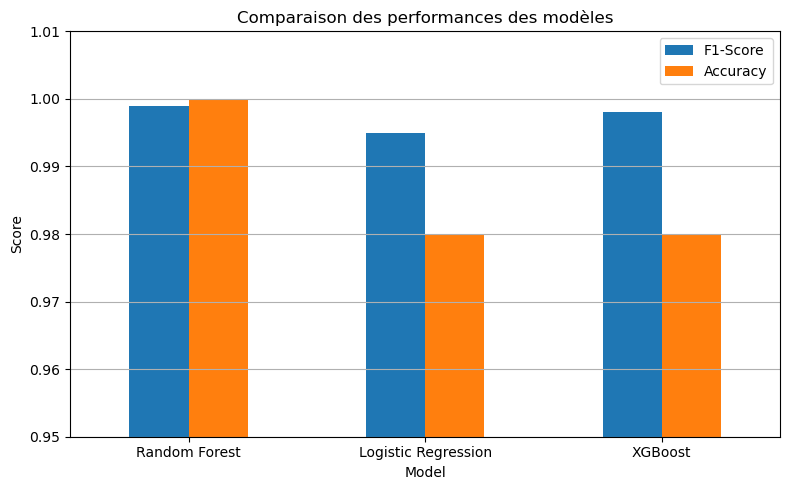

In [1888]:
import matplotlib.pyplot as plt
import pandas as pd

# Résultats des modèles (à ajuster si tu as de nouvelles valeurs)
model_names = ['Random Forest', 'Logistic Regression', 'XGBoost']
f1_scores = [0.9990, 0.9949, 0.9980]
accuracy = [1.00, 0.98, 0.98]

# Création du DataFrame
df_results = pd.DataFrame({
    'Model': model_names,
    'F1-Score': f1_scores,
    'Accuracy': accuracy
})

# Affichage graphique
fig, ax = plt.subplots(figsize=(8, 5))
df_results.set_index('Model')[['F1-Score', 'Accuracy']].plot(kind='bar', ax=ax)
plt.title('Comparaison des performances des modèles')
plt.ylabel('Score')
plt.ylim(0.95, 1.01)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


J’ai choisi Random Forest car il combine simplicité, puissance, robustesse et performance, tout en obtenant des résultats excellents sur mes données actuelles.
C’est le meilleur compromis pour un déploiement fiable et interprétable.
Accuracy c'est % de prédictions correctes et F1-score c'est Qualité globale du modèle

In [1892]:
# Taux de retard par fournisseur
retard_par_fournisseur = df_supply.groupby("SupplierID")["IsLate"].mean().sort_values(ascending=False)

print(retard_par_fournisseur.head(10))  # Top 10 fournisseurs les plus souvent en retard


SupplierID
96     1.0
151    1.0
98     1.0
144    1.0
145    1.0
93     1.0
146    1.0
147    1.0
149    1.0
86     1.0
Name: IsLate, dtype: float64


In [1894]:
# Moyenne des retards par fournisseur
retard_par_fournisseur = df_supply.groupby("SupplierID")["IsLate"].mean()

# Fournisseurs toujours à l’heure (0% de retard)
fournisseurs_a_temps = retard_par_fournisseur[retard_par_fournisseur == 0.0]

print("📋 Fournisseurs toujours à l’heure :")
print(fournisseurs_a_temps.index.tolist())


📋 Fournisseurs toujours à l’heure :
[2, 5, 14, 46, 57, 95, 113, 118, 135, 136, 137, 138, 140, 150, 160]


In [1896]:
# Split 80% train / 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [1898]:
# Réentraîner uniquement sur les données d'entraînement
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [1900]:
# Prédiction sur les données de test
y_pred_test = model.predict(X_test)

# Évaluation
print("📊 Confusion Matrix (test set):")
print(confusion_matrix(y_test, y_pred_test))

print("\n📋 Rapport de classification :")
print(classification_report(y_test, y_pred_test))

📊 Confusion Matrix (test set):
[[89  1]
 [ 1 98]]

📋 Rapport de classification :
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        90
           1       0.99      0.99      0.99        99

    accuracy                           0.99       189
   macro avg       0.99      0.99      0.99       189
weighted avg       0.99      0.99      0.99       189



Exporter le modèle pour le réutiliser plus tard

In [1903]:
import joblib

# Sauvegarder le modèle
joblib.dump(model, "modele_retard_rf.pkl")

# (Optionnel) Sauvegarder aussi les features
joblib.dump(features, "features_retard.pkl")


['features_retard.pkl']

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_31940\2261114601.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette="coolwarm")
C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_31940\2261114601.py:12: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
C:\Users\GIGABYTE\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


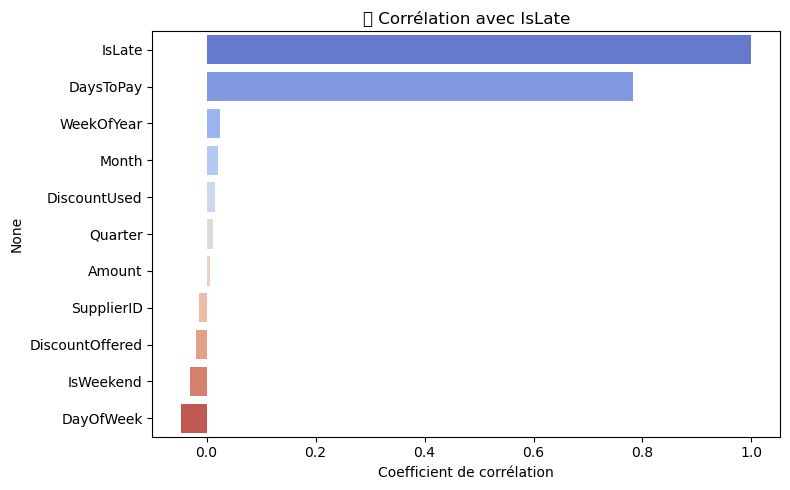

In [1905]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul de la corrélation
correlations = df_supply[features + ["IsLate"]].corr()["IsLate"].sort_values(ascending=False)

# Affichage
plt.figure(figsize=(8, 5))
sns.barplot(x=correlations.values, y=correlations.index, palette="coolwarm")
plt.title("🔍 Corrélation avec IsLate")
plt.xlabel("Coefficient de corrélation")
plt.tight_layout()
plt.show()


In [1907]:
def predict_retard(paiement_dict):
    import pandas as pd
    import joblib

    # Charger le modèle et les colonnes
    model = joblib.load("modele_retard_rf.pkl")
    features = joblib.load("features_retard.pkl")

    # Créer un DataFrame avec une ligne
    df_test = pd.DataFrame([paiement_dict])[features]

    # Prédiction
    prediction = model.predict(df_test)[0]
    proba = model.predict_proba(df_test)[0][1]

    return {
        "Prediction": int(prediction),
        "Proba_Late": round(proba, 4)
    }


In [1909]:
paiement = {
    "Amount": 182400,
    "DiscountOffered": 1100,
    "DiscountUsed": 80,
    "DaysToPay": 60,
    "DayOfWeek": 2,
    "WeekOfYear": 14,
    "IsWeekend": 0,
    "Month": 4,
    "Quarter": 2,
    "SupplierID": 1
}

result = predict_retard(paiement)
print(result)


{'Prediction': 1, 'Proba_Late': 0.73}
